# Projeto facerecog

In [1]:
#pacotes = !pip freeze

In [2]:
#%%writefile requirements.txt

# lista extensa do environment, depois filtro para os que foram utilizados realmente
#ipython==5.1.0
#jupyter==1.0.0
#matplotlib==1.5.3
#notebook==4.2.3
#numpy==1.11.2
#pandas==0.18.1
#Pillow==3.4.1
#pytesseract==0.1.6
#scikit-image==0.12.3
#scikit-learn-0.18
#scipy==0.18.1
#seaborn==0.7.1

# the following must be installed separately
# opencv==3.1.0
# tesseract

In [3]:
# uncomment line below to install requirements (recommended to use a virtualenv)
#!pip install -r requirements.txt

-----------------------

# Importação de pacotes

In [4]:
%matplotlib inline
""" handling files support packages """
from glob import glob

""" logic support packages """
import numpy as np
import pytesseract
import itertools
import csv
import pandas as pd

""" plot support packages """
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

""" image trasformation packages """
from PIL import Image
import skimage.io as skio
from skimage.util import dtype_limits
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.morphology import label, skeletonize
from skimage.filters import rank
from skimage import color
from skimage import restoration
from skimage import feature
from skimage.measure import compare_ssim, compare_mse
from sklearn.preprocessing import binarize

""" statistical data visualization packages"""
import seaborn as sns

""" seaborn configurations """
sns.set_style('white')
sns.set_context('talk')
plt.rcParams['figure.figsize'] = 20, 10

In [5]:
from funcoes import mse, compare_images, load_image, save_image, plot_captchas, save_images, crop_char, feed_char_dict, ler_letras, checar_combinacoes, remove_small_blobs, run_tesseract

----------------------------

# Leitura das imagens iniciais funções de suporte

In [6]:
img_files = sorted(glob('../imagens/captcha*.png'))
#print(img_files)
imgs = skio.imread_collection(img_files)
#print(imgs.files)

In [7]:
#plot_captchas(imgs)

In [8]:
unblobbed = [remove_small_blobs(img, background=255) for img in imgs]
#plot_captchas(unblobbed)

------------------------

# Extração e arquivo das letras dos primeiros captchas

In [9]:
captcha_letters = dict()
captcha_letters.clear()
#print(captcha_letters == {})

In [10]:
# 6º caractere
cropped = [crop_char(img, 5) for img in unblobbed ]
#plot_captchas( cropped, (4, 5) )

In [11]:
letters = ('9', 'g', 'b', 'q', 'o',
           'x', 'b', 'L', 'R', 'M',
           'L', 'L', '3', 'E', 'z',
           '1', '1', 'e', 'A', 'u')
# o, x, M, u

feed_char_dict(captcha_letters, letters, cropped)

In [12]:
# 5º caractere
cropped = [crop_char(img, 4) for img in unblobbed ]
#plot_captchas( cropped, (4, 5) )

In [13]:
letters = ('k', 'B', 'g', 'c', 'L',
           's', 'F', 'd', 'o', 'A',
           'y', '7', 'k', 'y', 'J',
           'q', 'k', 'z', '3', 'x')

feed_char_dict(captcha_letters, letters, cropped)

In [14]:
# 4º caractere
cropped = [crop_char(img, 3) for img in unblobbed ]
#plot_captchas( cropped, (4, 5) )

In [15]:
letters = ('j', '6', '6', 's', 'L',
           'f', 'E', '5', 'w', 'a',
           'i', 's', 'F', 'b', 'M',
           's', 'k', '3', 'v', 'h')

feed_char_dict(captcha_letters, letters, cropped)

In [16]:
# 3º caractere
cropped = [crop_char(img, 2) for img in unblobbed ]
#plot_captchas( cropped, (4, 5) )

In [17]:
letters = ('p', 'v', 'y', 'g', 's',
           '2', 'n', 'B', 's', 'i',
           'k', 'a', 'p', 'v', 'z',
           't', 'E', 'c', 'G', 'A')

feed_char_dict(captcha_letters, letters, cropped)

In [18]:
# 2º caractere
cropped = [crop_char(img, 1) for img in unblobbed ]
#plot_captchas( cropped, (4, 5) )

In [19]:
letters = ('v', 'w', 'z', 'Q', 'R',
           '3', 'H', 'q', 's', 's',
           'm', 'u', 'a', 'M', 'D',
           'y', '9', 'p', 'o', 'n')

feed_char_dict(captcha_letters, letters, cropped)

In [20]:
# 1º caractere
cropped = [crop_char(img, 0) for img in unblobbed ]
#plot_captchas( cropped, (4, 5) )

In [21]:
letters = ('v', 'T', 'g', '8', 's',
           'k', 'n', 'q', 'w', 'g',
           'E', 'j', 'i', '4', '6',
           'A', 'v', '9', '9', 'w')

feed_char_dict(captcha_letters, letters, cropped)

----------

# Inclusão dos novos captchas

À partir daqui farei a inclusão dos novos captchas no dicionário já criado **captcha_letters**:

In [22]:
img_files = sorted(glob('../imagens/gerarCaptcha.asp*.png'))
#print(img_files)
imgs = skio.imread_collection(img_files)

In [23]:
#plot_captchas(imgs, (10, 10))

In [24]:
unblobbed = [remove_small_blobs(img, background=255) for img in imgs]
#plot_captchas(unblobbed, (10, 10))

In [25]:
# 6º caractere
cropped = [crop_char(img, 5) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

In [26]:
letters = ('D', 'm', 'n', '4', 'k', 'J', '8', 'u', '3', '6',
            '3', 'z', 'c', 'x', 'u', 'e', 'B', 'w', 'y', '1',
            'u', 'x', '2', 's', '5', 'a', 'v', 'G', '7', 'h',
            'r', 'P', 'f', '1', 's', '6', 'v', '4', 'h', 'A',
            '4', 'R', 't', 'x', 'G', 'j', 'n', '1', '4', 'z',
            'p', 'u', 's', '9', 'c', 'r', '3', 'G', 'k', 'G',
            's', 't', 'A', '8', 'Q', 's', 'o', 'T', 'h', '5',
            'M', 'z', 'G', 's', '6', 'y', 'k', 'w', 'B', 'p',
            'c', 'a', 's', 'G', '2', '3', 'N', 'A', 'z', 'y',
            'p', 'Q', 'B', 'U', 'd', 'A', 'H', 'B', '2', 's')

feed_char_dict(captcha_letters, letters, cropped)

In [27]:
# 5º caractere
cropped = [crop_char(img, 4) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

In [28]:
letters = ('8', 'u', 'H', 'q', 'p', 'x', 'j', 'y', 'k', 'j',
            'w', 'j', 'p', 'x', 'x', 'p', 'q', '1', 'u', 'G',
            'a', 'w', 'p', 'M', 'w', 'w', 'g', 'E', 'g', 'x',
            'r', '1', 'c', '9', 'y', 'N', 'N', 'D', 'J', 'g',
            'h', 'j', 'B', '5', 'a', 'L', '6', '8', 'x', 'E',
            'R', 'u', 'v', 'q', 'T', '5', 'w', 's', 'F', 'T',
            'i', '7', '6', 'J', 'z', '1', 'b', 'v', '7', 'D',
            'N', 'v', 'e', 'q', 'v', 'r', 'm', 'r', 'e', 'B',
            'o', 'm', 'y', 'k', 'a', 'H', 'c', 'u', 'j', 'd',
            'q', 'p', 'r', '2', 'B', 'c', 'H', 'D', 'Q', 'h')

feed_char_dict(captcha_letters, letters, cropped)

In [29]:
# 4º caractere
cropped = [crop_char(img, 3) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

In [30]:
letters = ('n', 'n', 'G', 'Q', 'x', 'M', 'A', 'u', 'x', 'n',
            't', 'H', 'y', 'v', 'x', 'k', '5', 'E', 'p', '9',
            's', '1', 'J', 'L', 'z', 'H', 'M', '7', 'T', 'h',
            '6', 's', 'R', '8', 'H', '9', 'T', 'F', 'Q', 'e',
            's', 'B', '3', 'v', 'L', '8', 'A', 'x', 'p', 'u',
            'v', 's', 'q', 'd', 'e', 'u', 'm', 'k', 'B', 'E',
            'a', 't', 'F', 's', 'n', 'E', 'y', 'T', '4', '5',
            'l', 'a', '6', 'p', 'v', 'J', '7', 'i', 'm', 'J',
            'n', 'i', 'a', '7', 'b', '3', '7', 'p', '3', 'v',
            '1', 'y', 'R', 'k', 'T', 'v', 'p', 'p', 'c', 'u')

feed_char_dict(captcha_letters, letters, cropped)

In [31]:
# 3º caractere
cropped = [crop_char(img, 2) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

In [32]:
letters = ('j', 'n', '1', 'R', 'r', 't', 'o', 'w', 'n', 'c',
          'r', 'o', 'm', 'a', 'd', 'e', 'M', 'y', 'u', 'F',
          'o', 'N', 'y', '8', 'p', 't', 'i', 'n', 'v', 'q',
          'r', 's', 'b', 'r', '1', '8', 'Q', 'G', 'o', 'o',
          '4', 'q', '5', 'T', 'b', 'e', 'f', 'v', '1', 'i',
          'a', 'H', 'w', 's', 'v', 'H', 'H', 'd', 'H', '1',
          '6', 'y', '6', '8', 'z', 'n', 'F', 'n', 'f', 'B',
          'e', 'm', '9', 'A', 'r', '4', 'a', 'T', 'o', 'q',
          'j', 'u', 'A', 'y', 'D', 'p', 'E', 'p', 'H', '1',
          '5', 'n', 'b', '6', '4', 'd', '5', 'H', 'G', 'c')

feed_char_dict(captcha_letters, letters, cropped)

In [33]:
# 2º caractere

cropped = [crop_char(img, 1) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

In [34]:
letters = ('m', 's', 'k', 'v', 'c', 'L', 'R', 'w', 'x', 'g',
          'v', 'h', 'k', 'T', '7', 'R', '7', 'y', 's', 'z',
          'o', '4', 'o', 'e', 'A', 'z', 'J', '8', 'i', 'y',
          '8', 'v', 'p', 'm', 'a', 'o', 'w', 'u', 'k', 'N',
          'e', 'Q', '3', 'b', 'b', 'c', 'c', '7', 'z', 'T',
          'T', '5', 'M', 'z', 'k', '3', 'r', 'N', 'c', 'k',
          '9', 'n', 'u', 'y', '3', 'u', 'v', '1', 'A', 'n',
          'J', 'v', 'n', 'x', 'y', '3', 'u', 'H', 'R', 'c',
          'W', 'g', 'x', 'F', '2', 'v', 'o', 'E', 'v', '1',
          'd', '3', 'x', '7', 'L', 'g', 'z', 'H', 'r', 's')

feed_char_dict(captcha_letters, letters, cropped)

In [35]:
# 1º caractere
cropped = [crop_char(img, 0) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

In [36]:
letters = ('r', 'J', 'c', 'w', 'j', 'p', 'u', 'D', 'p', 'p',
          'i', 'p', 'p', '4', 'b', 'u', 't', 'L', 'y', '5',
          'F', '9', '7', 'E', 'A', 'L', 'f', 'c', 'T', 'a',
          'E', 'k', 'a', '8', 'w', 'H', 'k', 's', 's', 'r',
          'w', 'p', 'k', 'N', 'D', 'E', 'p', 'E', 'z', 'y',
          '7', 'g', 'n', 'u', 'm', 'x', '7', 'k', 'y', 'z',
          'z', 'N', 't', 'g', 'n', 'v', 'h', 'e', 'R', 'o',
          's', 'z', 'r', '1', '8', 'v', 'q', 'p', 'n', 'N',
          '3', 'E', 'N', '1', 'D', 'G', 'x', 'h', 'u', 'A',
          'F', 'w', '4', 'R', '9', 'H', 'a', 'p', 'c', 'B')

feed_char_dict(captcha_letters, letters, cropped)

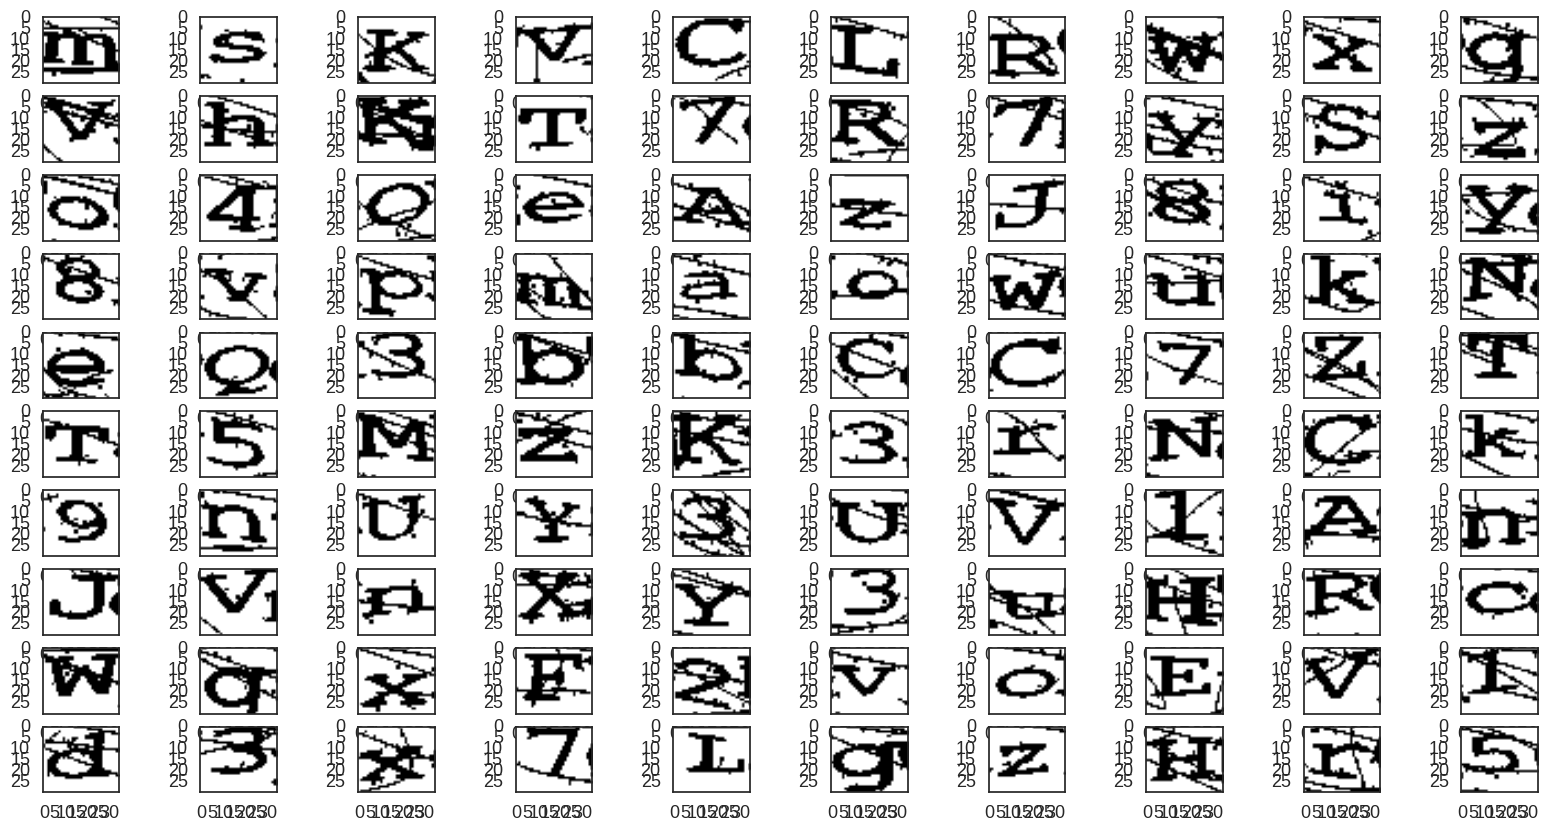

In [37]:
cropped = [crop_char(img, 1, x1 = 10, x2 = 40) for img in unblobbed ]
#plot_captchas( cropped, (10, 10) )

# Salvar base de dados de Letras

In [38]:
save_images(captcha_letters)

---------------------------------
# Alguns testes

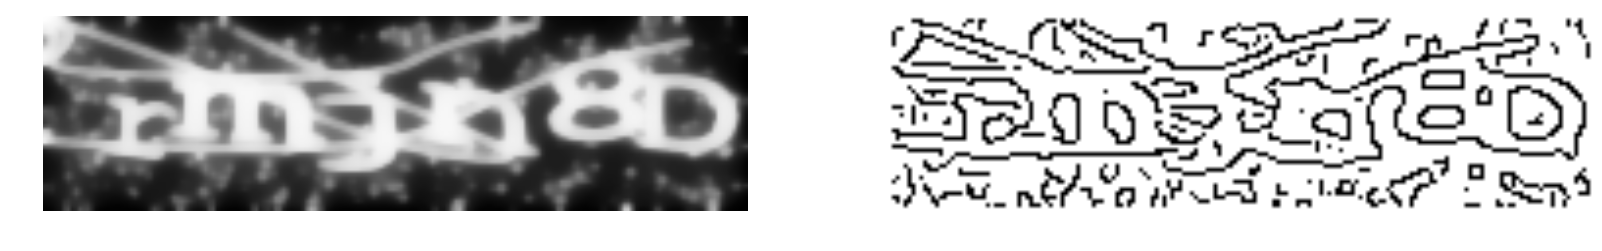

In [39]:
# tentativa de melhores filtros

image = color.rgb2gray(skio.imread(img_files[0]))
denoised = restoration.denoise_tv_bregman(image, 1)
edges = feature.canny(denoised, 1, 0.01, 0.1)

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(denoised)
axes[1].imshow(edges)
for ax in axes:
    ax.set_axis_off()
plt.show()

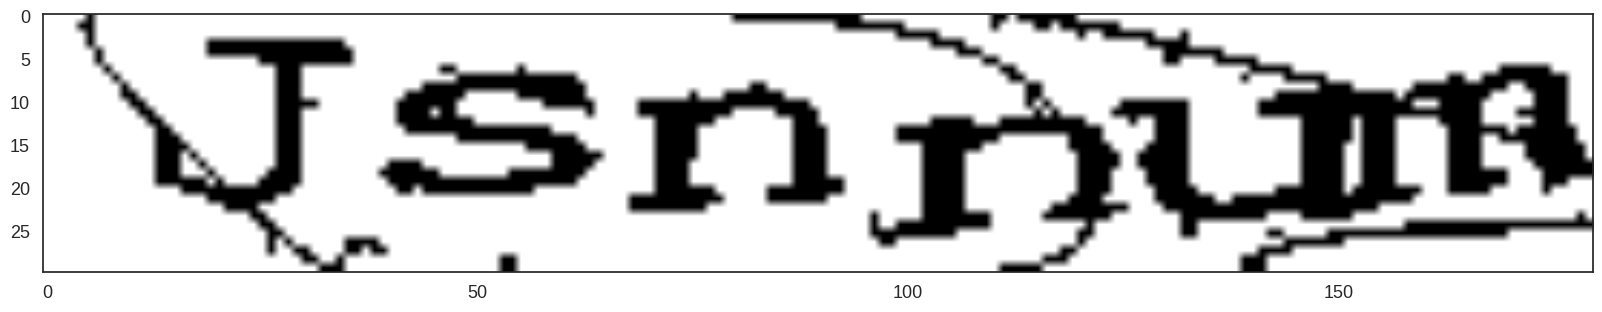

In [40]:
plt.imshow(np.invert(binarize(unblobbed[1][10:40, : , 0])))

/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarit

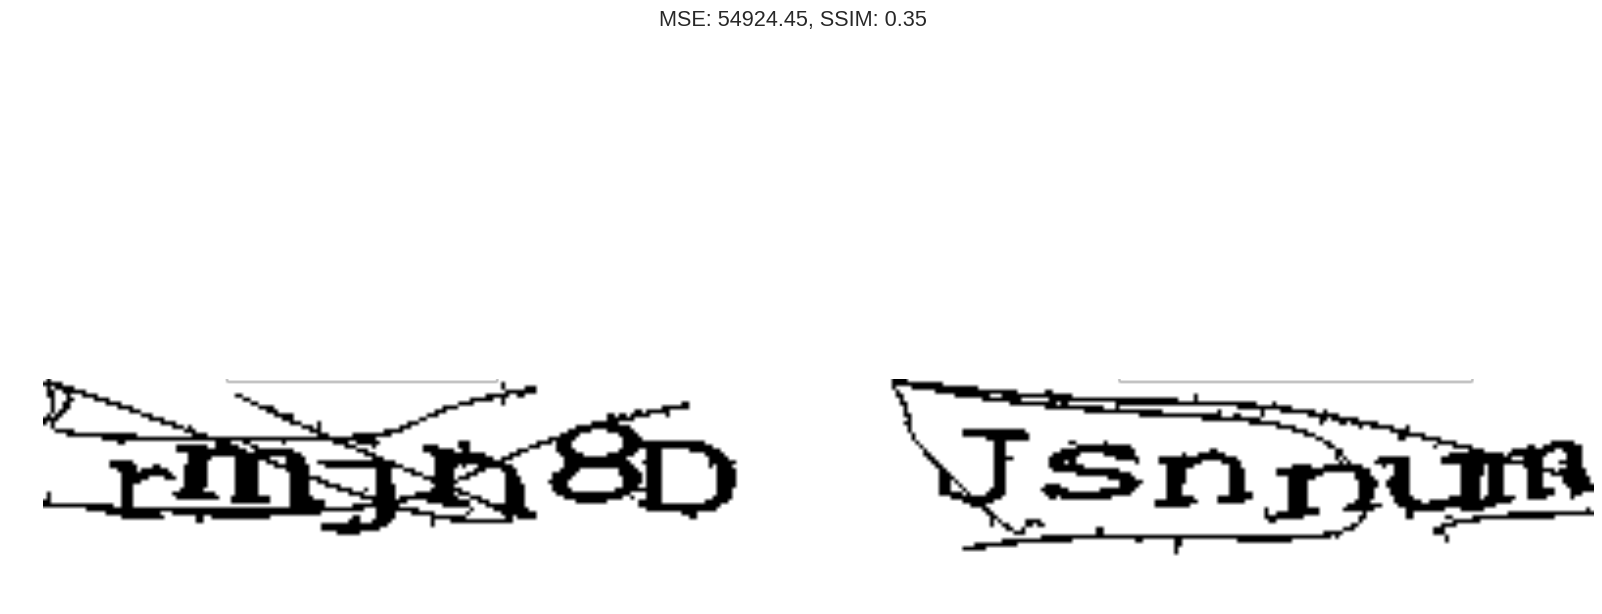

In [41]:
compare_images(unblobbed[0], unblobbed[1], "two captchas", plot=True)

/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarit

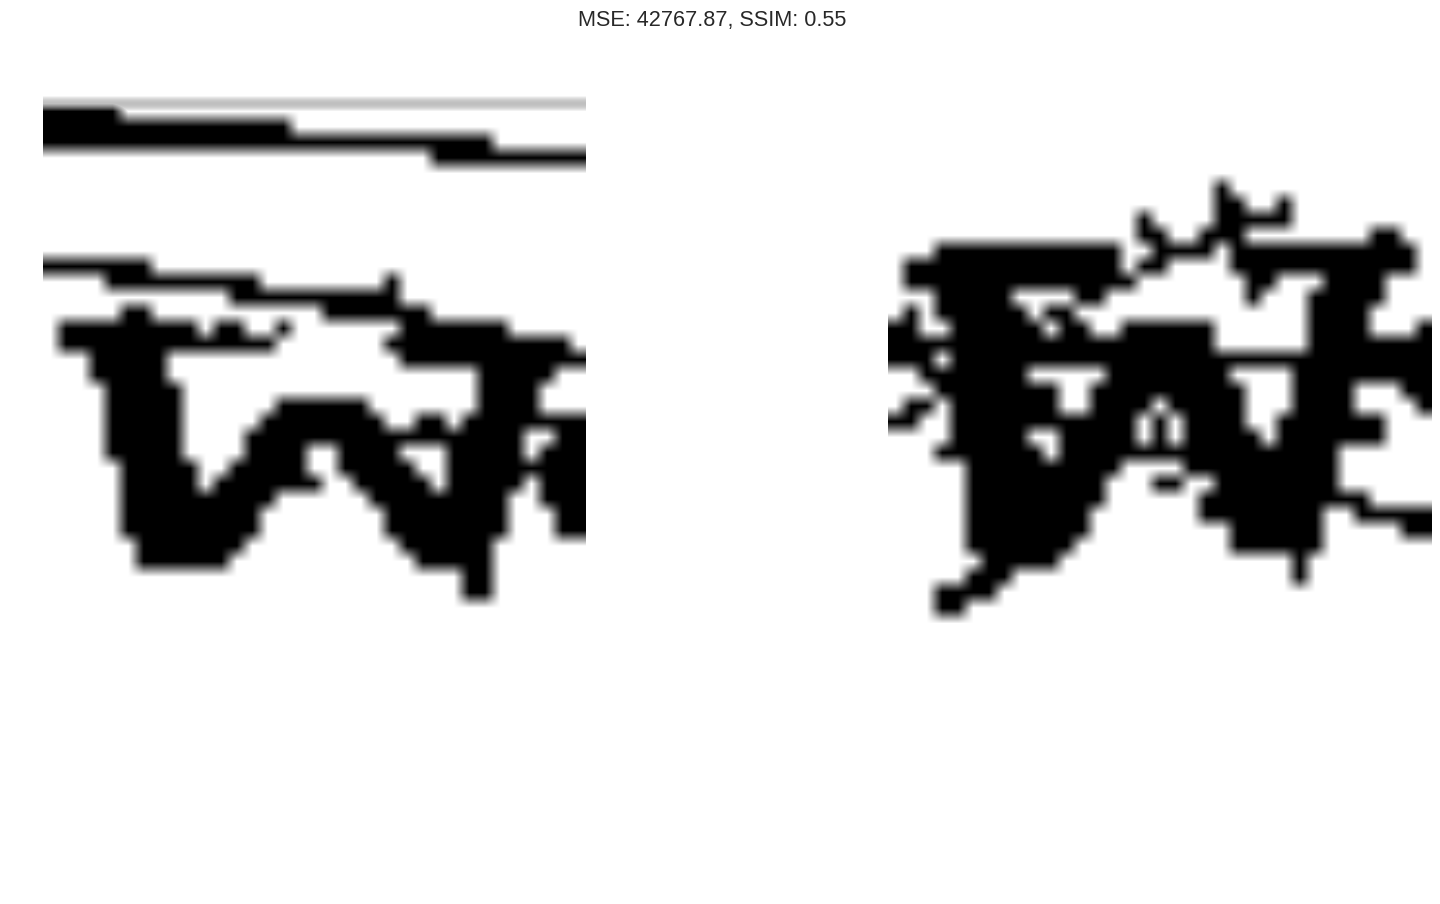

In [42]:
compare_images(captcha_letters['w'][0], captcha_letters['w'][1], "two W's", plot=True)

/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarit

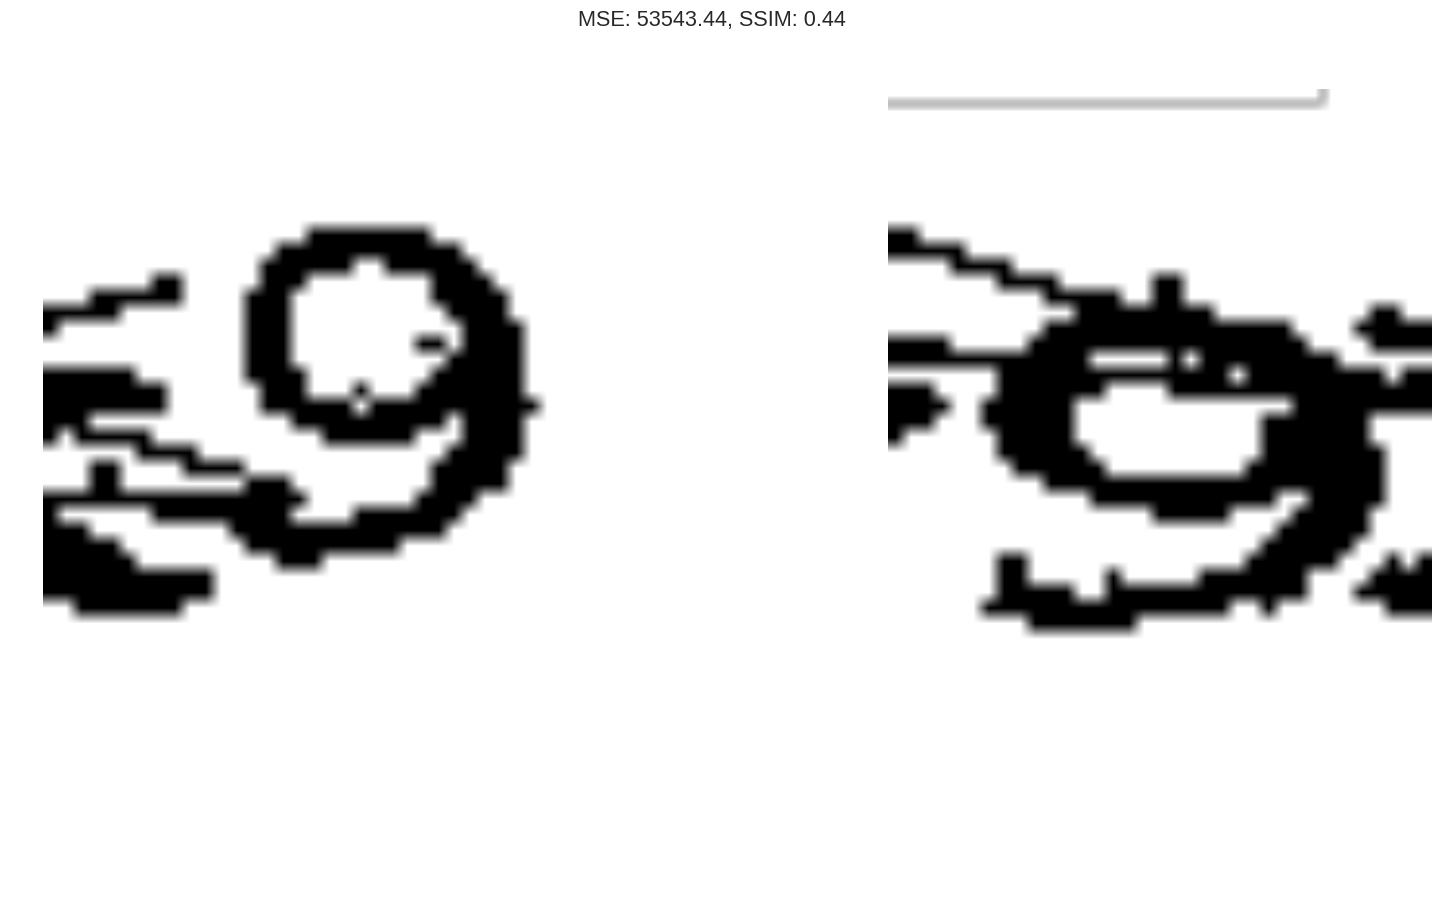

In [43]:
compare_images(captcha_letters['9'][0], captcha_letters['9'][1], "two 9's", plot=True)

/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarity``. Use ``compare_ssim`` instead.
  def structural_similarity(X, Y, win_size=None, gradient=False,
/home/ricardo/envs/facerecog/lib/python3.5/site-packages/skimage/measure/_structural_similarity.py:224: skimage_deprecation: Call to deprecated function ``structural_similarit

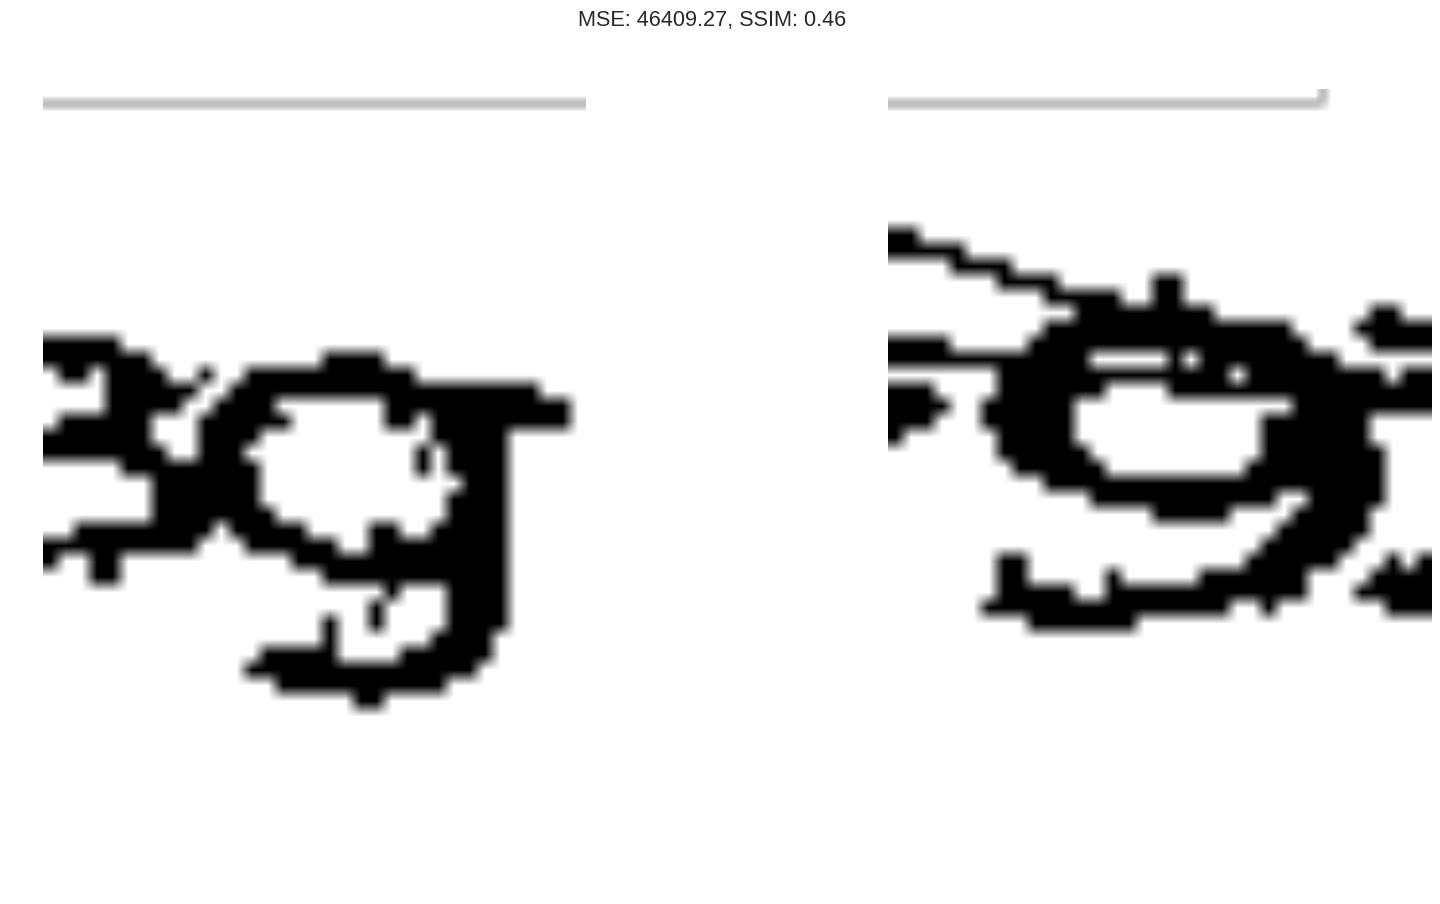

In [44]:
compare_images(captcha_letters['g'][0], captcha_letters['9'][1], "two differents", plot=True)